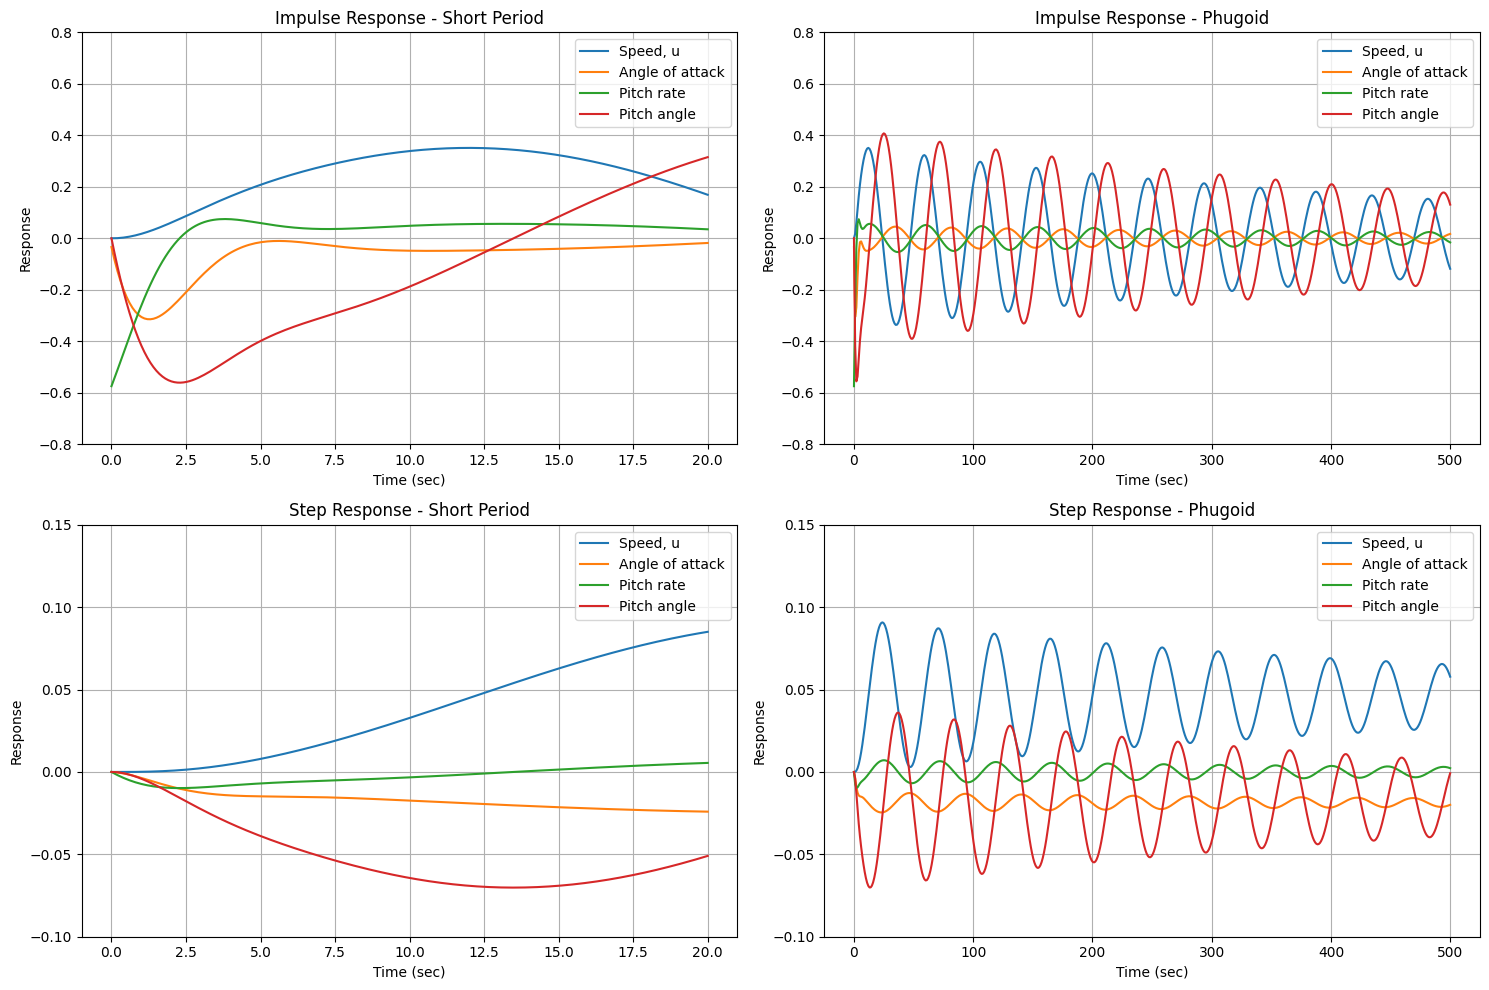

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, solve_continuous_are

A = np.array([
    [-0.0212, 0.0466, 0.0000, -0.1153],
    [-0.2229, -0.5839, 0.9404, 0.0000],
    [0.0150, -0.5031, -0.5015, 0.0000],
    [0.0000, 0.0000, 1.0000, 0.0000]
])

B = np.array([[0.0000], 
              [-0.0340], 
              [-0.5746], 
              [0.0000]])

eta0 = np.pi/180  # Convert 1 degree to radians bc engineers use degrees for some stupid reason

def impulse_response(t):
    return np.dot(expm(A * t), B).flatten()

def step_response(t):
    # Implementing equation 6.43:
    # x(t) = [e^(At) - I]A^(-1)Bη0
    A_inv = inv(A)
    exp_At = expm(A * t)
    return eta0 * np.dot(exp_At - np.eye(4), np.dot(A_inv, B)).flatten()

t_short = np.linspace(0, 20, 200)
t_long = np.linspace(0, 500, 500)

impulse_short = np.array([impulse_response(t) for t in t_short])
impulse_long = np.array([impulse_response(t) for t in t_long])
step_short = np.array([step_response(t) for t in t_short])
step_long = np.array([step_response(t) for t in t_long])

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(t_short, impulse_short[:, 0], label='Speed, u')
plt.plot(t_short, impulse_short[:, 1], label='Angle of attack')
plt.plot(t_short, impulse_short[:, 2], label='Pitch rate')
plt.plot(t_short, impulse_short[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Impulse Response - Short Period')
plt.legend()
plt.ylim(-0.8, 0.8)

plt.subplot(2, 2, 2)
plt.plot(t_long, impulse_long[:, 0], label='Speed, u')
plt.plot(t_long, impulse_long[:, 1], label='Angle of attack')
plt.plot(t_long, impulse_long[:, 2], label='Pitch rate')
plt.plot(t_long, impulse_long[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Impulse Response - Phugoid')
plt.legend()
plt.ylim(-0.8, 0.8)

plt.subplot(2, 2, 3)
plt.plot(t_short, step_short[:, 0], label='Speed, u')
plt.plot(t_short, step_short[:, 1], label='Angle of attack')
plt.plot(t_short, step_short[:, 2], label='Pitch rate')
plt.plot(t_short, step_short[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Step Response - Short Period')
plt.legend()
plt.ylim(-0.1, 0.15)

plt.subplot(2, 2, 4)
plt.plot(t_long, step_long[:, 0], label='Speed, u')
plt.plot(t_long, step_long[:, 1], label='Angle of attack')
plt.plot(t_long, step_long[:, 2], label='Pitch rate')
plt.plot(t_long, step_long[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Step Response - Phugoid')
plt.legend()
plt.ylim(-0.1, 0.15)

plt.tight_layout()
plt.show()


Feedback gain matrix K:
[ 0.54489592  0.37201294 -1.3011773  -1.21155802]

Augmented system matrix A*:
[[-0.0212      0.0466      0.         -0.1153    ]
 [-0.20437354 -0.57125156  0.89615997 -0.04119297]
 [ 0.3280972  -0.28934136 -1.24915648 -0.69616124]
 [ 0.          0.          1.          0.        ]]

Feedback gain matrix K:
[ 0.54489592  0.37201294 -1.3011773  -1.21155802]

Augmented system matrix A*:
[[-0.0212      0.0466      0.         -0.1153    ]
 [-0.20437354 -0.57125156  0.89615997 -0.04119297]
 [ 0.3280972  -0.28934136 -1.24915648 -0.69616124]
 [ 0.          0.          1.          0.        ]]


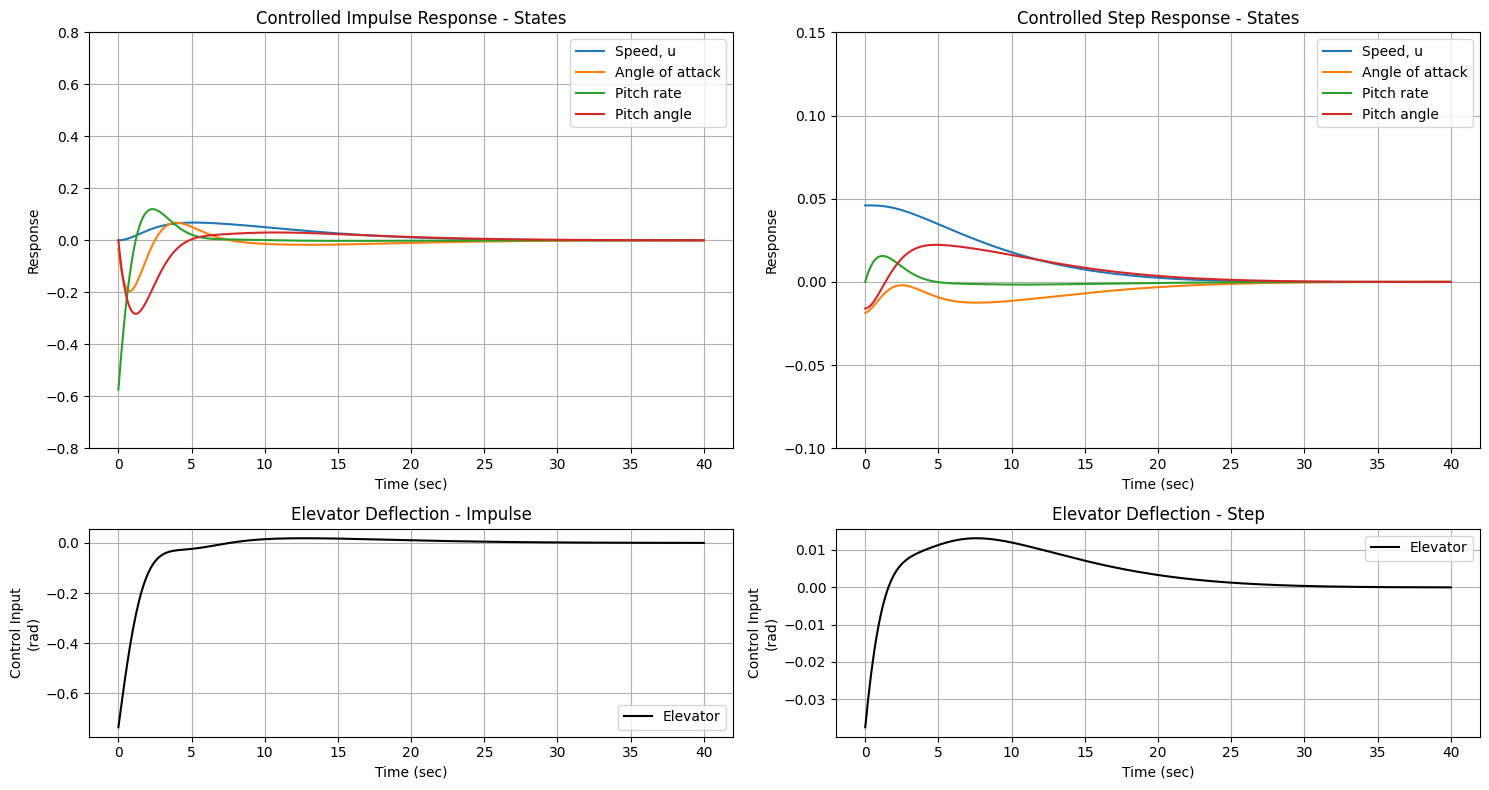


Maximum elevator deflections:
Impulse: 0.7350 radians = 42.11 degrees
Step: 0.0375 radians = 2.15 degrees


In [5]:
def compute_controlled_response(t, x0, c=1.0):
    """Compute controlled system response and control input"""
    Q = np.eye(4)  
    R = (1/c**2) * np.eye(1)
    
    # Solve Riccati equation and get K
    P = solve_continuous_are(A, B, Q, R)
    K = (1/R[0,0]) * B.T @ P
    
    # Calculate augmented matrix
    A_cl = A - B @ K
    
    # Print the important matrices
    print("\nFeedback gain matrix K:")
    print(K.flatten())
    print("\nAugmented system matrix A*:")
    print(A_cl)
    
    # State response
    response = np.zeros((len(t), 4))
    for i, ti in enumerate(t):
        response[i] = expm(A_cl * ti) @ x0
    
    # Control input
    control = -K @ response.T
    
    return response, control.flatten()

t = np.linspace(0, 40, 400)

x0_impulse = B.flatten()
x0_step = eta0 * np.dot(np.linalg.inv(-A), B).flatten()

controlled_impulse, control_impulse = compute_controlled_response(t, x0_impulse)
controlled_step, control_step = compute_controlled_response(t, x0_step)

fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t, controlled_impulse[:, 0], label='Speed, u')
ax1.plot(t, controlled_impulse[:, 1], label='Angle of attack')
ax1.plot(t, controlled_impulse[:, 2], label='Pitch rate')
ax1.plot(t, controlled_impulse[:, 3], label='Pitch angle')
ax1.grid(True)
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Response')
ax1.set_title('Controlled Impulse Response - States')
ax1.legend()
ax1.set_ylim(-0.8, 0.8)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(t, control_impulse, 'k-', label='Elevator')
ax2.grid(True)
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Control Input\n(rad)')
ax2.set_title('Elevator Deflection - Impulse')
ax2.legend()

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(t, controlled_step[:, 0], label='Speed, u')
ax3.plot(t, controlled_step[:, 1], label='Angle of attack')
ax3.plot(t, controlled_step[:, 2], label='Pitch rate')
ax3.plot(t, controlled_step[:, 3], label='Pitch angle')
ax3.grid(True)
ax3.set_xlabel('Time (sec)')
ax3.set_ylabel('Response')
ax3.set_title('Controlled Step Response - States')
ax3.legend()
ax3.set_ylim(-0.1, 0.15)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t, control_step, 'k-', label='Elevator')
ax4.grid(True)
ax4.set_xlabel('Time (sec)')
ax4.set_ylabel('Control Input\n(rad)')
ax4.set_title('Elevator Deflection - Step')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nMaximum elevator deflections:")
print(f"Impulse: {np.max(np.abs(control_impulse)):.4f} radians = {np.max(np.abs(control_impulse))*180/np.pi:.2f} degrees")
print(f"Step: {np.max(np.abs(control_step)):.4f} radians = {np.max(np.abs(control_step))*180/np.pi:.2f} degrees")


Results for c = 0.1:
Feedback gain K = [ 0.0040133   0.07604987 -0.10479625 -0.12458284]
Eigenvalues:
λ_1 = -0.5542+0.6896j
λ_2 = -0.5542-0.6896j
λ_3 = -0.0279+0.1334j
λ_4 = -0.0279-0.1334j
Maximum elevator gain: 0.1246

Results for c = 0.5:
Feedback gain K = [ 0.19998619  0.28510525 -0.62652441 -0.6263738 ]
Eigenvalues:
λ_1 = -0.6122+0.7207j
λ_2 = -0.6122-0.7207j
λ_3 = -0.1163+0.1203j
λ_4 = -0.1163-0.1203j
Maximum elevator gain: 0.6265

Results for c = 1.0:
Feedback gain K = [ 0.54489592  0.37201294 -1.3011773  -1.21155802]
Eigenvalues:
λ_1 = -0.7487+0.7768j
λ_2 = -0.7487-0.7768j
λ_3 = -0.1721+0.0897j
λ_4 = -0.1721-0.0897j
Maximum elevator gain: 1.3012

Results for c = 2.0:
Feedback gain K = [ 1.23417822  0.33049703 -2.55511086 -2.35407457]
Eigenvalues:
λ_1 = -1.0722+0.8466j
λ_2 = -1.0722-0.8466j
λ_3 = -0.2096+0.0358j
λ_4 = -0.2096-0.0358j
Maximum elevator gain: 2.5551

Results for c = 5.0:
Feedback gain K = [ 3.2297401  -0.17677729 -5.88480706 -5.75241579]
Eigenvalues:
λ_1 = -2.0201

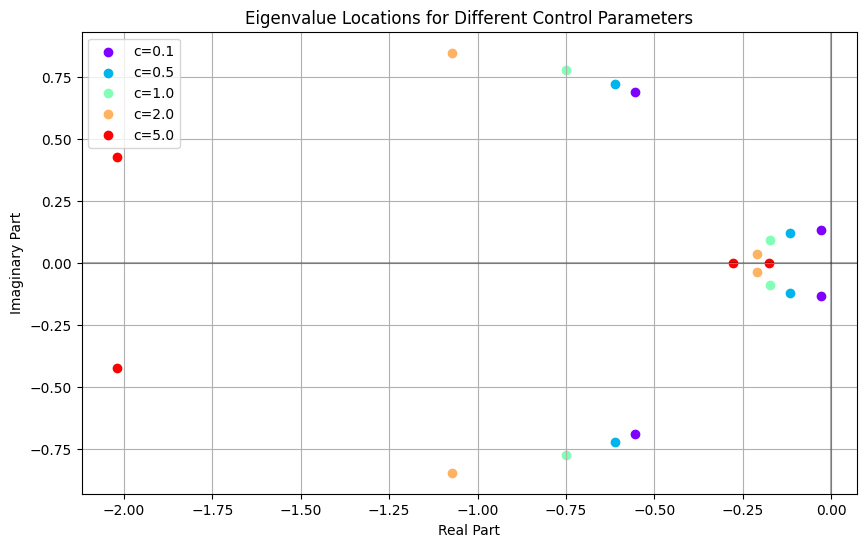

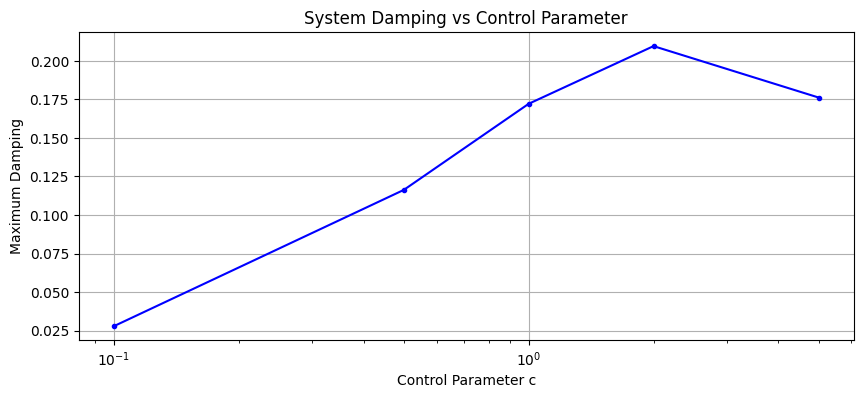

In [7]:
import numpy as np
from scipy.linalg import expm, solve_continuous_are, eigvals
import matplotlib.pyplot as plt

def analyze_control_system(c_values):
    """Analyze system response and eigenvalues for different c values"""
    results = {}
    
    for c in c_values:
        # Setup matrices
        Q = np.eye(4)
        R = (1/c**2) * np.eye(1)
        
        # Solve Riccati equation
        P = solve_continuous_are(A, B, Q, R)
        K = (1/R[0,0]) * B.T @ P
        
        # Compute augmented matrix and its eigenvalues
        A_cl = A - B @ K
        eigs = eigvals(A_cl)
        
        # Store results
        results[c] = {
            'K': K,
            'A_cl': A_cl,
            'eigenvalues': eigs,
            'max_real': np.max(np.real(eigs)),
            'min_real': np.min(np.real(eigs))
        }
        
        # Print analysis
        print(f"\nResults for c = {c}:")
        print(f"Feedback gain K = {K.flatten()}")
        print("Eigenvalues:")
        for i, eig in enumerate(eigs):
            print(f"λ_{i+1} = {eig:.4f}")
        print(f"Maximum elevator gain: {np.max(np.abs(K)):.4f}")
    
    return results

# Analyze range of c values
c_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = analyze_control_system(c_values)

# Plot eigenvalue locations
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(c_values)))

for c, color in zip(c_values, colors):
    eigs = results[c]['eigenvalues']
    plt.scatter(np.real(eigs), np.imag(eigs), 
               label=f'c={c}', color=color)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalue Locations for Different Control Parameters')
plt.legend()
plt.show()

# Plot damping characteristics
plt.figure(figsize=(10, 4))
real_parts = [results[c]['max_real'] for c in c_values]
plt.semilogx(c_values, -np.array(real_parts), 'b.-')
plt.grid(True)
plt.xlabel('Control Parameter c')
plt.ylabel('Maximum Damping')
plt.title('System Damping vs Control Parameter')
plt.show()